# **Desafio de Classificação - Gabriel Dantas de Moraes Almeida**

## **Importação de bibliotecas**

In [1]:
import os
import kagglehub

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

## **Carregamento do banco de dados**

In [2]:
databaseFolder = kagglehub.dataset_download("uciml/adult-census-income")
csvPath = os.path.join(databaseFolder, 'adult.csv')

In [3]:
df = pd.read_csv(csvPath)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## **Análise e tratamento do banco de dados**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Percebe-se que existem dados categóricos e numéricos. Além disso, existem valores faltantes no banco de dados.

Para tratar esses valores, vamos inicialmente converter "?" para NaN.

In [5]:
df.replace('?', pd.NA, inplace=True)

Para visualizar como os dados faltantes estão distribuidos, podemos fazer o seguinte:

In [6]:
missing = df.isnull().sum()
missing

,0
age,0
workclass,1836
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,1843
relationship,0
race,0
sex,0


Além disso, podemos analisar a integridade percentual do banco de dados:

In [7]:
total = len(df)
full_lines = df.dropna().shape[0]
percentage = (full_lines / total) * 100

print(f"{percentage:.2f}% das linhas estão sem valores faltantes.")

92.63% das linhas estão sem valores faltantes.


Como temos um dataset grande e a quantidade de dados faltantes não é tão expressiva, uma solução simples e segura é remover as linhas quem contém valores NaN.

In [8]:
df = df.dropna()

Além disso, vamos analisar se o banco de dados é balanceado. Para isso, podemos ver como os "incomes" estão distribuidos.

In [9]:
df['income'].value_counts()

,count
income,
<=50K,22654
>50K,7508


Nota-se que o banco de dados é muito desbalanceado. Devemos considerar isso na implementação dos modelos.

Além disso, para que nossos modelos intepretem os dados corretamente, precisaremos converter variáveis categóricas em numéricas.

Podemos fazer isso por meio do one-hot encoding com `drop_first=True` para evitar multicolinearidade entre as colunas.

In [10]:
df_encoded = pd.get_dummies(df, drop_first=True).astype('int64')
df_encoded.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia,income_>50K
1,82,132870,9,0,4356,18,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,54,140359,4,0,3900,40,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,41,264663,10,0,3900,40,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
5,34,216864,9,0,3770,45,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
6,38,150601,6,0,3770,40,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [11]:
df_encoded.dtypes.value_counts()

,count
int64,97


Nota-se que agora todos os dados são numéricos. Podemos prosseguir para a implementação dos modelos.

## **Implementação do modelo de Decision Tree**

Inicialmente dividimos as variáveis livres da variável alvo.

Em seguida, faz-se a divisão do conjunto de dados em duas partes: uma para treinamento e outra para o teste dos modelos.

In [12]:
X = df_encoded.drop('income_>50K', axis=1)
y = df_encoded['income_>50K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Podemos definir o modelo de Decision Tree especificando alguns parâmetros:

In [13]:
tree = DecisionTreeClassifier(
    max_depth=10,             # Profundidade máxima
    min_samples_split=10,     # Mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=1,       # Mínimo de amostras que um nó folha pode ter
    random_state=42,          # Reprodutibilidade dos resultados
    criterion='entropy',      # Métrica usada para dividir os nós
    class_weight='balanced'   # Ajusta os pesos das classes desbalanceadas
)

tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_split=10, random_state=42)

## **Implementação do modelo de Random Forest**

Podemos também definir o modelo de Random Forest especificando alguns parâmetros:

In [14]:
forest = RandomForestClassifier(
      n_estimators=1000,         # Número de árvores
      max_depth=50,              # Profundidade máxima de cada árvore
      min_samples_split=10,      # Mínimo de amostras necessárias para dividir um nó
      min_samples_leaf=1,        # Número mínimo de amostras em uma folha
      random_state=42,           # Reprodutibilidade dos resultados
      class_weight='balanced'    # Ajusta os pesos das classes desbalanceadas
  )

forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=50,
                       min_samples_split=10, n_estimators=1000,
                       random_state=42)

## **Comparação dos modelos**

Para comparar os modelos, criou-se uma função que exibe as métricas de interesse e o mapa de confusão para cada modelo.

In [15]:
def getModelInfo(X_test, name=None):
  accuracy = accuracy_score(y_test, X_test)
  precision = precision_score(y_test, X_test)
  recall = recall_score(y_test, X_test)
  f1 = f1_score(y_test, X_test)

  print(f'Modelo: {name}')
  print(f'Acurácia: {accuracy:.4f}')
  print(f'Precisão: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1-Score: {f1:.4f}\n')

  # Gerar a matriz de confusão
  cm = confusion_matrix(y_test, X_test)

  # Plotar a matriz de confusão
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['income <=50K', 'income >50K'], yticklabels=['income <=50K', 'income >50K'])
  plt.title('Matriz de Confusão')
  plt.xlabel('Predição')
  plt.ylabel('Real')
  plt.show()

A depender da aplicação do modelo, pode-se querer priorizar o **recall**, ou seja, deseja-se que o modelo identifique corretamente a maioria dos casos positivos reais, minimizando falsos negativos. Em outros casos, pode-se querer priorizar o **precision**.

**Por exemplo:** suponha que o governo irá taxar salários anuais que superem 50.000,00 $. Nesse caso, espera-se que a precisão no diagnóstico de "income > 50K" seja alta, para evitar que pessoas com salário inferior a esse valor sejam taxadas indevidamente (falsos positivos).

Como o contexto específico não nos foi dado, busquei focar a análise no **F1-Score**, que é a média harmônica entre precisão e recall, oferecendo um equilíbrio entre essas duas métricas.


### **Análise do modelo de decision tree**


Modelo: Decision Tree
Acurácia: 0.8130
Precisão: 0.5896
Recall: 0.8160
F1-Score: 0.6846



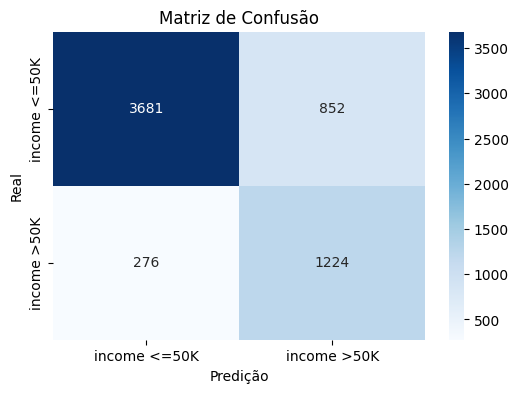

In [16]:
getModelInfo(tree.predict(X_test), 'Decision Tree')



*   **Acurácia de 0.8130:** o modelo classificou corretamente 81,30% dos exemplos no conjunto de dados de teste;
*   **Precisão de 0.5896:** ao testar o modelo com dados que ele não viu durante o treinamento, aproximadamente 58,96% das previsões feitas pelo modelo estavam corretas;
*   **Recall de 0.8160:** esse resultado nos indica que aproximadamente 81,60% dos resultados diagnosticados como "income > 50K" foram diagnosticados corretamente;
*   **F1-Score de 0.6846:** esse resultado significa que o modelo tem um equilíbrio razoável entre precisão e recall, acertando bem as classificações positivas.



Além disso, o mapa de confusão nos mostra que há em média uma maior tendência de acerto para casos cujo income seja inferior a 50K. Isso se deve ao desbalanceamento do banco de dados fornecido.

### **Análise do modelo de random forest**


Modelo: Random Forest
Acurácia: 0.8467
Precisão: 0.6710
Recall: 0.7520
F1-Score: 0.7092



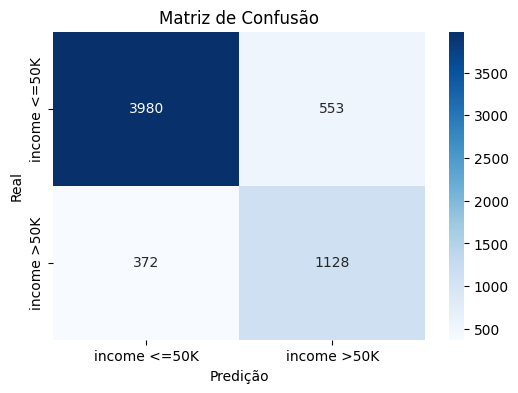

In [17]:
getModelInfo(forest.predict(X_test), 'Random Forest')



*   **Acurácia de 0.8467:** o modelo classificou corretamente 84,67% dos exemplos no conjunto de dados de teste;
*   **Precisão de 0.6710:** ao testar o modelo com dados que ele não viu durante o treinamento, aproximadamente 67,10% das previsões feitas pelo modelo estavam corretas;
*   **Recall de 0.7520:** esse resultado nos indica que aproximadamente 75,20% dos resultados diagnosticados como "income > 50K" foram diagnosticados corretamente;
*   **F1-Score de 0.7092:** esse resultado significa que o modelo tem um bom equilíbrio entre precisão e recall.

Novamente, o mapa de confusão nos mostra que há em média uma maior tendência de acerto para casos cujo income seja inferior a 50K. Isso se deve ao desbalanceamento do banco de dados fornecido.

Evidentemente houve uma melhoria em todos os parâmetros exceto o recall ao se comparar com o decision tree.

Por meio da implementação do modelo de random forest, obteve-se um aumento expressivo sobretudo na precisão (diferença de 8,14%).



### **Gráfico de importância de atributos**

Com o intuito de compreender qual a importância de cada atributo com relação ao income, elaborou-se o gráfico abaixo, que exibe as 10 variáveis mais importantes.

In [18]:
def plot_feature_importance(model):
  importances = model.feature_importances_

  indices = np.argsort(importances)[-10:] # seleciona top 10

  plt.figure(figsize=(6, 4))
  plt.title('10 Atributos mais Importantes')
  plt.barh(range(len(indices)), importances[indices], align='center')
  plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
  plt.xlabel('Importância')
  plt.tight_layout()
  plt.show()

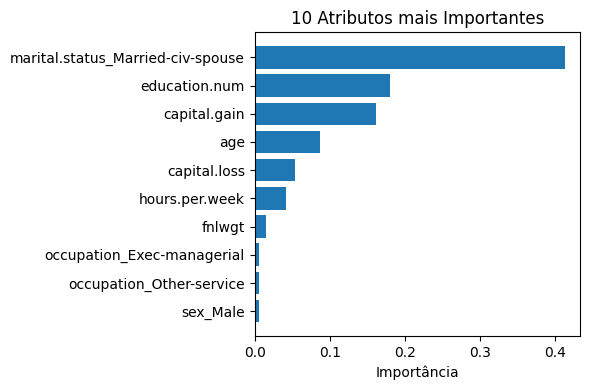

In [19]:
plot_feature_importance(tree)

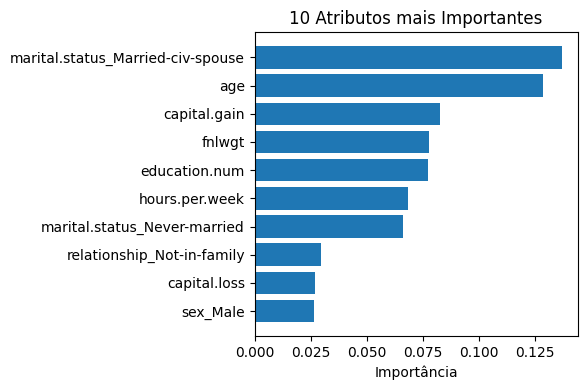

In [20]:
plot_feature_importance(forest)